In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import LocalOutlierFactor

from NEExT.collections import EgonetCollection
from NEExT.experiment_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.experiment_utils.embed import build_embeddings, build_features
from NEExT.io import GraphIO
from NEExT.outliers import OutlierDataset

%reload_ext autoreload
%autoreload 2

In [14]:
graph_io = GraphIO()

edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data()
# edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data()

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    # "feature_list": [],
    "feature_list": [i for i in features_df.columns[1:-1]],
}

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/pygod/utils/utility.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [15]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=1,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=5, feature_list=graph_data["feature_list"])

In [16]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy="structural_embedding",
    structural_embedding_dimension=5,
    feature_embedding_dimension=5,
    embedding_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)

In [11]:
model = 'LOF' # 'IF'

hyperparames = {
    'LOF': [int(i * 10) for i in [0.5, 1, 5, 10, 15]],
    'IF': [int(i * 10) for i in [0.5, 1, 5, 10, 25, 100]],
}

res = []
for i in hyperparames[model]:
    if model == 'LOF':
        detector = LocalOutlierFactor(n_neighbors=i)
    elif model == 'IF':
        detector = IsolationForest(n_estimators=i)
    y_pred = detector.fit_predict(dataset.X_unlabeled)
    y_pred = np.where(y_pred == 1, 0, 1)
    s = roc_auc_score(ground_truth_df["is_outlier"], y_pred)
    res.append(s)
    

np.mean(res), np.std(res), np.max(res)

1 0.6693766937669378
10 0.768970189701897
50 0.790650406504065
100 0.7567750677506776
250 0.7628726287262872
1000 0.7567750677506776
0.7509033423667569 0.038220964243047155 0.790650406504065


<Axes: xlabel='emb_0_struct', ylabel='emb_1_struct'>

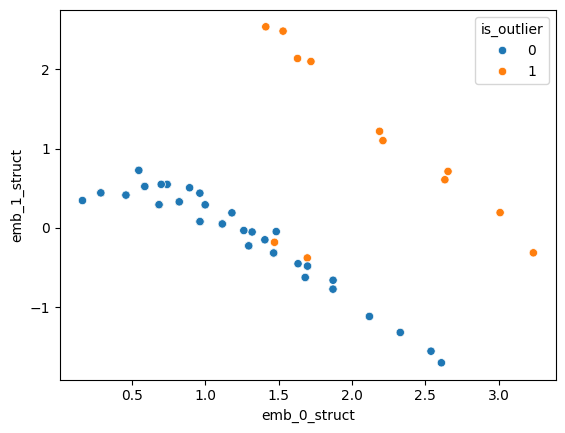

In [12]:
sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"])